<a href="https://colab.research.google.com/github/albertopolini/DSIM/blob/main/DSIM_E02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio track *classification*


In [ ]:
# In this notebook we are going to classify the numbers from 0 to 9 using a series of audio tracks

In [2]:
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav

import matplotlib.pyplot as plt
import IPython.display as ipd

# Classification tools
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# File management
from google.colab import drive
import tarfile
from shutil import copyfile

# Advanced audio features
import librosa
import librosa.display as lid
from sklearn.preprocessing import scale

In [8]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [9]:
copyfile('gdrive/MyDrive/recordings.tar', 'recordings.tar')
tar=tarfile.open('recordings.tar')
tar.extractall()
tar.close()

## Data Loader

In [10]:
# Placecholder for feature extractor
def identity(input):
  return input

# Crop the input signal to same the lenght (100)
def crop(input, limit=100):
  if len(input) >= limit:
    return input[:limit]
  else:
    lenght = len(input)
    return np.concatenate((input, np.zeros(limit - lenght)))

# Data loader
def load_data(feature_extractor=identity, normalize=False):
    
    labels = []
    features = []

    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            # Load file and compute the requested features
            _, signal = wav.read('./recordings/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Classes
            label = f.split('_')[0]
            labels.append(label)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test


In [17]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=crop)

In [18]:
len(X_train)

1350

In [19]:
X_train[0].shape

(100,)

# Train the classifier (SVM)

In [21]:
clf = SVC(kernel='rbf', class_weight='balanced')
dlf = clf.fit(X_train, y_train)

In [23]:
y_pred = clf.predict(X_test)

In [25]:
# Comparing with y_test

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.12      0.06      0.08        17
           1       0.27      0.30      0.29        10
           2       0.00      0.00      0.00        15
           3       0.27      0.16      0.20        19
           4       0.29      0.36      0.32        11
           5       0.00      0.00      0.00        14
           6       0.15      1.00      0.26        14
           7       0.00      0.00      0.00        19
           8       0.50      0.06      0.11        17
           9       0.33      0.07      0.12        14

    accuracy                           0.18       150
   macro avg       0.19      0.20      0.14       150
weighted avg       0.19      0.18      0.12       150



In [26]:
cm = confusion_matrix(y_test,y_pred)
print(cm)

[[ 1  3  0  2  0  0  9  1  0  1]
 [ 2  3  1  0  0  0  4  0  0  0]
 [ 0  0  0  1  2  0 11  0  1  0]
 [ 0  0  0  3  1  0 14  1  0  0]
 [ 0  1  0  1  4  2  3  0  0  0]
 [ 0  1  0  2  1  0  9  0  0  1]
 [ 0  0  0  0  0  0 14  0  0  0]
 [ 0  1  0  0  1  0 17  0  0  0]
 [ 2  0  0  2  5  1  6  0  1  0]
 [ 3  2  1  0  0  0  7  0  0  1]]


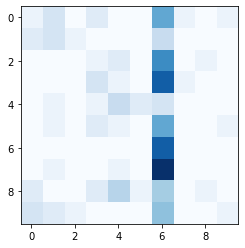

In [28]:
plt.imshow(cm, cmap=plt.cm.Blues)

# Let's try a new feature extraction function

## Standard deviation

In [31]:
def sdev(input):
  return np.std(input, keepdims=True)

In [33]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=sdev)

In [34]:
clf = SVC(kernel='rbf', class_weight='balanced')
clf = clf.fit(X_train, y_train)

In [35]:
y_pred = clf.predict(X_test)

In [36]:
# Comparing with y_test

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.29      0.12      0.17        17
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        15
           3       0.27      0.21      0.24        19
           4       0.13      0.27      0.18        11
           5       0.10      0.21      0.14        14
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00        19
           8       0.04      0.12      0.06        17
           9       0.16      0.29      0.21        14

    accuracy                           0.12       150
   macro avg       0.10      0.12      0.10       150
weighted avg       0.11      0.12      0.10       150



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
cm = confusion_matrix(y_test,y_pred)
print(cm)

[[2 0 0 0 3 0 0 2 7 3]
 [0 0 0 2 2 2 0 0 4 0]
 [0 0 0 2 1 5 0 1 3 3]
 [0 0 0 4 3 3 0 0 7 2]
 [3 0 0 0 3 1 0 0 1 3]
 [1 1 0 1 1 3 0 0 5 2]
 [0 0 0 1 4 1 0 0 7 1]
 [0 0 0 1 1 6 0 0 8 3]
 [1 0 0 2 4 4 0 0 2 4]
 [0 0 0 2 1 4 0 0 3 4]]


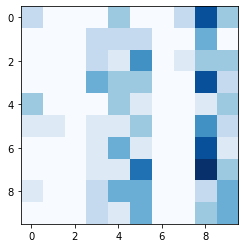

In [38]:
plt.imshow(cm, cmap=plt.cm.Blues)

##Standard deviation + Crop

In [57]:
def combo(input):
  return np.concatenate((crop(input), sdev(input)))

In [69]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=combo)

In [70]:
X_train[0].shape

(101,)

In [71]:
clf = SVC(kernel='rbf', class_weight='balanced')
clf = clf.fit(X_train, y_train)

In [72]:
y_pred = clf.predict(X_test)

In [73]:
# Comparing with y_test

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.29      0.12      0.17        17
           1       0.27      0.30      0.29        10
           2       1.00      0.13      0.24        15
           3       0.30      0.16      0.21        19
           4       0.23      0.27      0.25        11
           5       0.00      0.00      0.00        14
           6       0.18      0.29      0.22        14
           7       0.17      0.68      0.27        19
           8       0.50      0.06      0.11        17
           9       0.25      0.07      0.11        14

    accuracy                           0.21       150
   macro avg       0.32      0.21      0.19       150
weighted avg       0.32      0.21      0.18       150



In [74]:
cm = confusion_matrix(y_test,y_pred)
print(cm)

[[ 2  3  0  1  0  0  2  9  0  0]
 [ 1  3  0  0  0  0  0  5  0  1]
 [ 0  0  2  1  2  0  2  7  1  0]
 [ 0  0  0  3  1  0  3 12  0  0]
 [ 1  1  0  1  3  2  2  1  0  0]
 [ 0  1  0  2  1  0  3  6  0  1]
 [ 0  0  0  0  0  0  4 10  0  0]
 [ 0  0  0  0  1  0  5 13  0  0]
 [ 1  0  0  2  5  1  0  6  1  1]
 [ 2  3  0  0  0  0  1  7  0  1]]


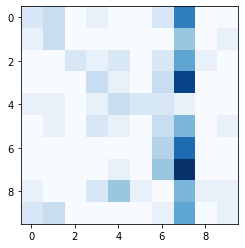

In [75]:
plt.imshow(cm, cmap=plt.cm.Blues)

# Applying the normalization

In [76]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=combo, normalize=
                                             True)

In [77]:
X_train[0].shape

(101,)

In [78]:
clf = SVC(kernel='rbf', class_weight='balanced')
clf = clf.fit(X_train, y_train)

In [79]:
y_pred = clf.predict(X_test)

In [80]:
# Comparing with y_test

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.44      0.24      0.31        17
           1       0.38      0.30      0.33        10
           2       0.80      0.27      0.40        15
           3       0.50      0.21      0.30        19
           4       0.29      0.36      0.32        11
           5       0.00      0.00      0.00        14
           6       0.19      0.36      0.25        14
           7       0.16      0.63      0.26        19
           8       1.00      0.06      0.11        17
           9       0.33      0.07      0.12        14

    accuracy                           0.25       150
   macro avg       0.41      0.25      0.24       150
weighted avg       0.42      0.25      0.24       150



In [81]:
cm = confusion_matrix(y_test,y_pred)
print(cm)

[[ 4  3  0  0  0  0  2  7  0  1]
 [ 2  3  1  0  0  0  0  4  0  0]
 [ 0  0  4  1  2  0  3  5  0  0]
 [ 0  0  0  4  1  0  2 12  0  0]
 [ 0  0  0  1  4  1  2  3  0  0]
 [ 0  0  0  2  1  0  3  7  0  1]
 [ 0  0  0  0  0  0  5  9  0  0]
 [ 0  0  0  0  1  0  6 12  0  0]
 [ 1  0  0  0  5  0  1  9  1  0]
 [ 2  2  0  0  0  0  2  7  0  1]]


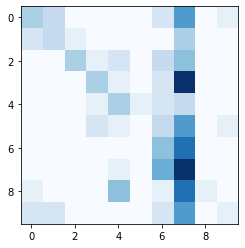

In [82]:
plt.imshow(cm, cmap=plt.cm.Blues)

## Hyperparameter optimization

In [84]:
param_grid = {'C':[100,500,1000],
              'gamma': [.005,.01,.1,.5,1.0]
              }

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid,
                   cv=2
                   )

In [87]:
clf = clf.fit(X_train, y_train)

In [93]:
clf.best_params_

{'C': 500, 'gamma': 0.1}

In [88]:
y_pred = clf.predict(X_test)

In [89]:
# Comparing with y_test

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.59      0.61        17
           1       0.41      0.70      0.52        10
           2       0.22      0.67      0.33        15
           3       0.62      0.26      0.37        19
           4       0.20      0.18      0.19        11
           5       0.33      0.07      0.12        14
           6       0.33      0.50      0.40        14
           7       0.13      0.11      0.12        19
           8       0.11      0.06      0.08        17
           9       0.60      0.21      0.32        14

    accuracy                           0.32       150
   macro avg       0.36      0.33      0.30       150
weighted avg       0.36      0.32      0.30       150



In [90]:
cm = confusion_matrix(y_test,y_pred)
print(cm)

[[10  2  2  0  0  0  1  0  1  1]
 [ 0  7  1  0  0  0  0  2  0  0]
 [ 0  0 10  0  0  0  1  2  1  1]
 [ 0  0  7  5  2  0  0  3  2  0]
 [ 0  1  6  0  2  0  1  1  0  0]
 [ 1  1  3  2  1  1  4  1  0  0]
 [ 0  0  1  1  2  0  7  1  2  0]
 [ 3  1  2  0  2  2  5  2  2  0]
 [ 0  2 11  0  1  0  0  2  1  0]
 [ 2  3  3  0  0  0  2  1  0  3]]


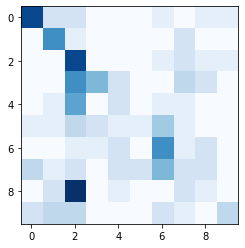

In [91]:
plt.imshow(cm, cmap=plt.cm.Blues)

# A better feature extractor
[MFCC](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum)

In [95]:
# Mel coefficients
def mfcc(input, rate=8000, min_len=40, sampling=1):
    # Sample values
    signal = input[::sampling]
    # Compute MFCC coefficients
    mfcc = librosa.feature.mfcc(signal*1.0, sr=int(rate/sampling))
    # Add additional necessary zeroes to reach the required length
    pad_width = min_len - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    # Flatten into monodimensional vector for the SVM
    mfcc = mfcc.flatten()
    return mfcc

In [96]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=mfcc, normalize=
                                             True)

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2033
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1963
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2007
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1976
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1987
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1886
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa

In [ ]:
X_train[0].shape

(101,)

In [97]:
param_grid = {'C':[100,500,1000],
              'gamma': [.005,.01,.1,.5,1.0]
              }

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid,
                   cv=2
                   )
clf = clf.fit(X_train, y_train)

In [99]:
clf.best_params_

{'C': 100, 'gamma': 0.005}

In [100]:
y_pred = clf.predict(X_test)

In [101]:
# Comparing with y_test

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        19
           4       1.00      1.00      1.00        11
           5       1.00      0.93      0.96        14
           6       0.82      1.00      0.90        14
           7       1.00      0.95      0.97        19
           8       1.00      1.00      1.00        17
           9       1.00      0.93      0.96        14

    accuracy                           0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150



In [102]:
cm = confusion_matrix(y_test,y_pred)
print(cm)

[[17  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0 15  0  0  0  0  0  0  0]
 [ 0  0  0 19  0  0  0  0  0  0]
 [ 0  0  0  0 11  0  0  0  0  0]
 [ 0  0  0  0  0 13  1  0  0  0]
 [ 0  0  0  0  0  0 14  0  0  0]
 [ 0  0  0  0  0  0  1 18  0  0]
 [ 0  0  0  0  0  0  0  0 17  0]
 [ 0  0  0  0  0  0  1  0  0 13]]


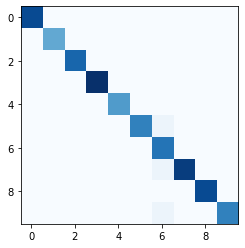

In [103]:
plt.imshow(cm, cmap=plt.cm.Blues)

# Exercize

Feature extractor based on zero crossing rate
[10,14,5,-5,-7,10]

ZCR = 2

How many times the sign changes:

[10,14,5,-5,-7,10]

[14 5 -5 -7 10 ?] translate

[+ + + - - + ] sign r1

[+ + - - + ?] sign r2

[0 0 1 0 1 ?]



In [117]:
def zrc(input):
  return sum([ input[index] * input[index+1] < 0
              for index in range(len(input[:-1]))
              ])